<a href="https://colab.research.google.com/github/WaSilveira/Sistema_reconhecimento_Facial/blob/main/Sistema_reconhecimento_Facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Instalação das bibliotecas
!pip install tensorflow opencv-python matplotlib scikit-learn keras
!pip install lz4==4.3.3
!pip install lz4
!pip install mtcnn

#Importação das bibliotecas
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mtcnn import MTCNN
import os
from PIL import Image, ImageDraw
import random



In [ ]:
#Funções auxiliares e geração de imagens de exemplo
def create_random_image(size=(100, 100)):
    image = Image.new('RGB', size, color=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))
    draw = ImageDraw.Draw(image)
    draw.ellipse((25, 25, 75, 75), fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))
    return image

# Gerar e salvar imagens de exemplo no Colab
base_dir = '/content/facial_recognition_dataset'
pessoas = ['pessoa1', 'pessoa2', 'pessoa3']

for pessoa in pessoas:
    os.makedirs(os.path.join(base_dir, pessoa), exist_ok=True)
    for i in range(2):
        filename = f'{pessoa}_foto{i+1}.jpg'
        filepath = os.path.join(base_dir, pessoa, filename)
        img = create_random_image()
        img.save(filepath)


In [ ]:
# Defina o caminho para seu conjunto de dados
data_dir = '/content/facial_recognition_dataset'

# Crie geradores de dados para treinamento e validação
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Ajuste para corresponder à entrada do modelo
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Ajuste para corresponder à entrada do modelo
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 15 images belonging to 4 classes.
Found 3 images belonging to 4 classes.


In [ ]:
# Construção e Treinamento do Modelo
def create_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

num_classes = len(train_generator.class_indices)
print(f"Número de classes no conjunto de dados: {num_classes}")

model = create_model(num_classes)
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)



Número de classes no conjunto de dados: 4
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2000 - loss: 1.3973 - val_accuracy: 0.3333 - val_loss: 6.5206
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 4.8639 - val_accuracy: 0.3333 - val_loss: 6.2594
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 4.4566 - val_accuracy: 0.3333 - val_loss: 3.0764
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 2.2692 - val_accuracy: 0.3333 - val_loss: 1.2550
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3333 - loss: 1.0416 - val_accuracy: 0.3333 - val_loss: 2.8334
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 1.6100 - val_accuracy: 0.3333 - val_loss: 2.8454
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4000 - loss: 0.9874 - val_accuracy: 0.0000e+00 - val_loss: 1.9121
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8000 - loss: 0.7503 - val_accura

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.0000e+00 - loss: 11.4525
Acurácia do teste: 0.0000


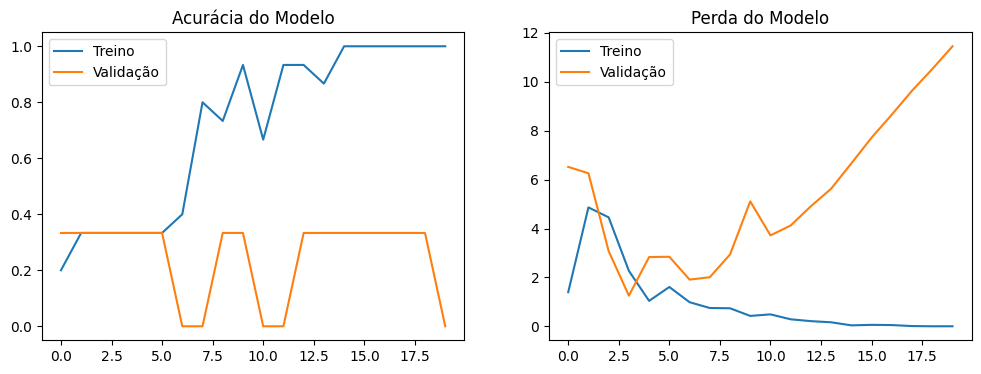

In [ ]:
# Avaliação e Visualização
# Avaliação
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Acurácia do teste: {test_acc:.4f}")

# Visualização
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.legend()
plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


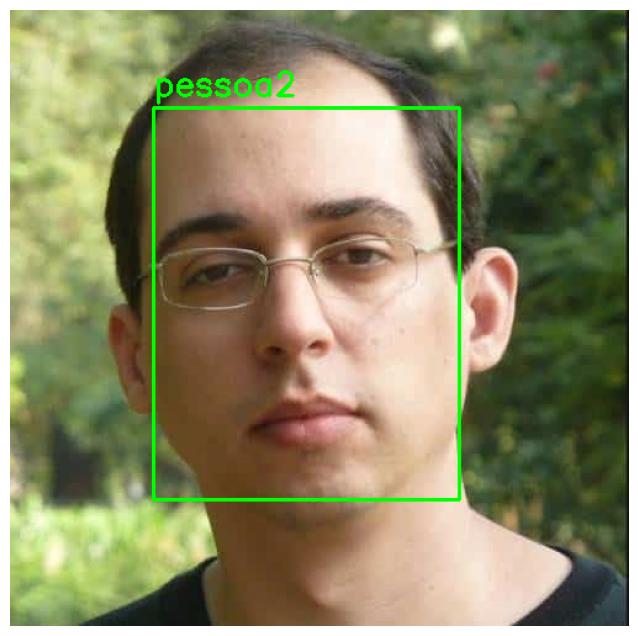

In [ ]:
#Detecção e reconhecimento facial
# Inicialize o detector MTCNN
# Inicialize o detector MTCNN
detector = MTCNN()

# Função para detectar e reconhecer faces
def detect_and_recognize_faces(image_path, model):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    faces = detector.detect_faces(image_rgb)

    for face in faces:
        x, y, w, h = face['box']
        face_img = image_rgb[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (224, 224))
        face_img = np.expand_dims(face_img, axis=0) / 255.0  # Pré-processamento

        # Reconhecimento facial usando o modelo treinado
        prediction = model.predict(face_img)
        class_index = np.argmax(prediction)
        class_label = list(train_generator.class_indices.keys())[class_index]

        cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image_rgb, class_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Exemplo de uso com uma imagem do diretório
example_image_path = '/content/facial_recognition_dataset/20201126145756.jpg'
detect_and_recognize_faces(example_image_path, model)





/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


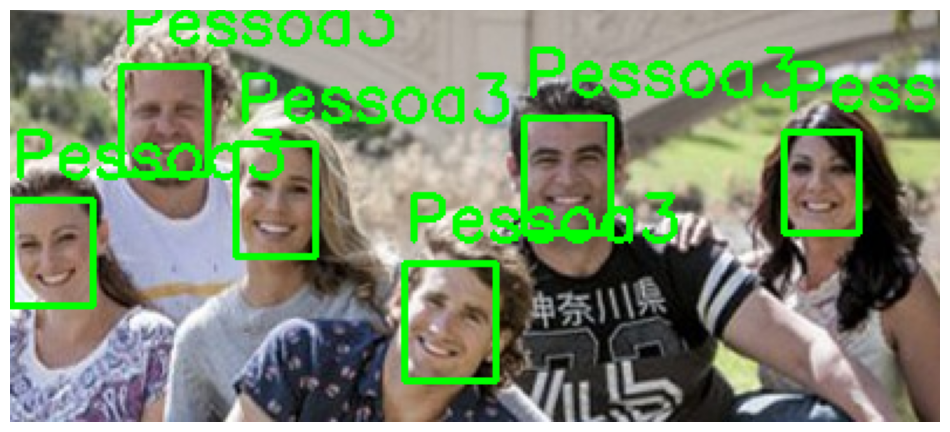

In [ ]:
#Implementação do reconhecimento facial
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential # Import the Sequential model if not already imported
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout # Import necessary layers

def recognize_face(face_img, model, class_names):
    face_img = cv2.resize(face_img, (224, 224))
    face_img = face_img.astype('float32') / 255.0
    face_img = np.expand_dims(face_img, axis=0)
    prediction = model.predict(face_img)
    person_id = np.argmax(prediction)
    return class_names[person_id]

def detect_and_recognize_faces(image_path, detector, class_names):
    # Recreate the model within the function scope
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(len(class_names), activation='softmax')  # Use len(class_names) for num_classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Load the weights if you have saved them
    # (Assuming you saved the weights to 'model_weights.h5')
    # model.load_weights('model_weights.h5')


    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    faces = detector.detect_faces(image_rgb)

    for face in faces:
        x, y, w, h = face['box']
        face_img = image_rgb[y:y+h, x:x+w]
        person_name = recognize_face(face_img, model, class_names) #Pass the local model to the function

        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, person_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Exemplo de uso
class_names = ['Pessoa1', 'Pessoa2', 'Pessoa3']  # Substitua pelos nomes reais das classes
# Call the function with the image path, detector, and class names
detect_and_recognize_faces('/content/Destacada_Poses_Grupos_f.JPG', detector, class_names)


Found 15 images belonging to 4 classes.
Found 3 images belonging to 4 classes.
Número de classes no conjunto de dados: 4
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4000 - loss: 1.3810 - val_accuracy: 0.3333 - val_loss: 3.4848
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6667 - loss: 1.1927 - val_accuracy: 0.3333 - val_loss: 6.9134
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3333 - loss: 5.2727 - val_accuracy: 0.0000e+00 - val_loss: 4.4352
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6667 - loss: 0.6976 - val_accuracy: 0.0000e+00 - val_loss: 6.1611
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6667 - loss: 0.8742 - val_accuracy: 0.3333 - val_loss: 5.6533
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7333 - loss: 0.5559 - val_accuracy: 0.0000e+00 - val_loss: 5.0905
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9333 - loss: 0.4351 - val_accuracy: 0.3333 - val_loss: 5.4642
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.2052 - val_accuracy: 0.0000e+00 - val_los

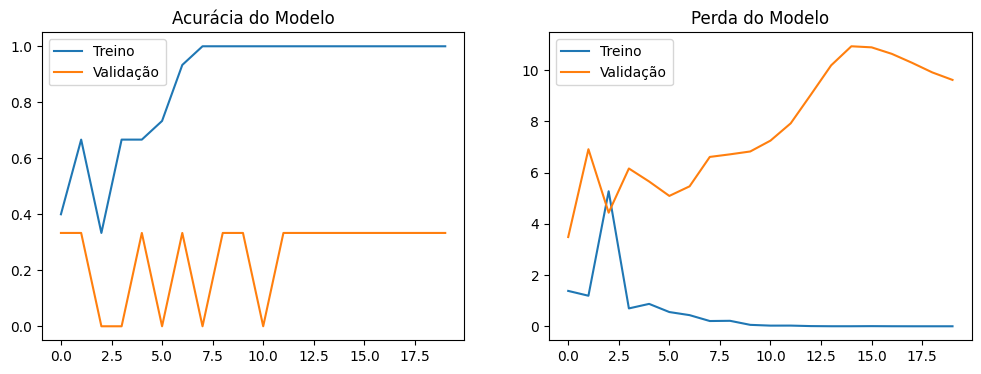

In [2]:
# Instalando bibliotecas necessárias
!pip install tensorflow opencv-python matplotlib scikit-learn keras mtcnn

# Importação das bibliotecas
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mtcnn import MTCNN
import os
from PIL import Image, ImageDraw
import random

# Funções auxiliares e geração de imagens de exemplo
def create_random_image(size=(100, 100)):
    image = Image.new('RGB', size, color=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))
    draw = ImageDraw.Draw(image)
    draw.ellipse((25, 25, 75, 75), fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))
    return image

# Gerar e salvar imagens de exemplo no Colab
base_dir = '/content/facial_recognition_dataset'
pessoas = ['pessoa1', 'pessoa2', 'pessoa3']

for pessoa in pessoas:
    os.makedirs(os.path.join(base_dir, pessoa), exist_ok=True)
    for i in range(2):
        filename = f'{pessoa}_foto{i+1}.jpg'
        filepath = os.path.join(base_dir, pessoa, filename)
        img = create_random_image()
        img.save(filepath)

# Defina o caminho para seu conjunto de dados
data_dir = '/content/facial_recognition_dataset'

# Crie geradores de dados para treinamento e validação
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Construção e Treinamento do Modelo
def create_model(num_classes):
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

num_classes = len(train_generator.class_indices)
print(f"Número de classes no conjunto de dados: {num_classes}")

model = create_model(num_classes)
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)

# Avaliação e Visualização
# Avaliação
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Acurácia do teste: {test_acc:.4f}")

# Visualização
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.legend()
plt.show()


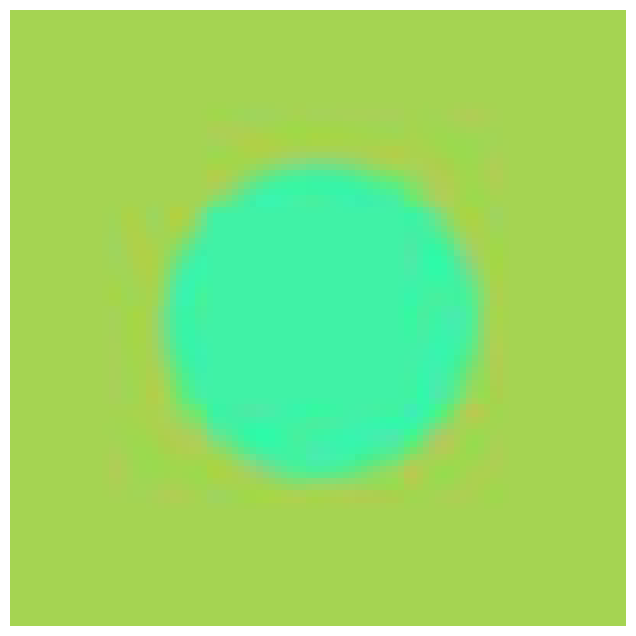

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


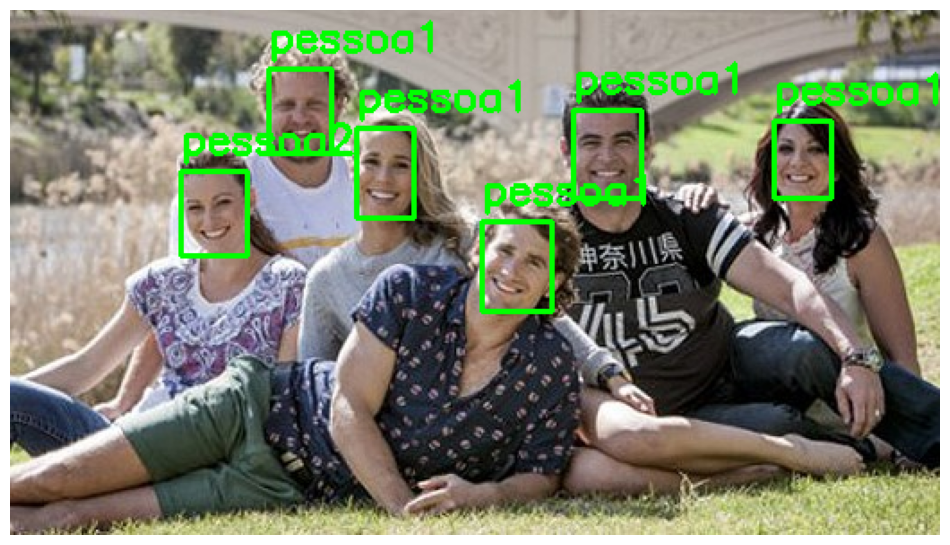

In [4]:
# Inicialize o detector MTCNN
detector = MTCNN()

# Função para reconhecer faces
def recognize_face(face_img, model, class_names):
    face_img = cv2.resize(face_img, (224, 224))
    face_img = face_img.astype('float32') / 255.0
    face_img = np.expand_dims(face_img, axis=0)
    prediction = model.predict(face_img)
    person_id = np.argmax(prediction)
    return class_names[person_id]

# Função para detectar e reconhecer faces
def detect_and_recognize_faces(image_path, model, detector, class_names):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    faces = detector.detect_faces(image_rgb)

    for face in faces:
        x, y, w, h = face['box']
        face_img = image_rgb[y:y+h, x:x+w]
        person_name = recognize_face(face_img, model, class_names)

        cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image_rgb, person_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Função para teste com múltiplas faces
def test_multiple_faces(image_path, model, detector, class_names):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    faces = detector.detect_faces(rgb_image)

    for face in faces:
        (left, top, width, height) = face['box']
        right = left + width
        bottom = top + height

        face_img = rgb_image[top:bottom, left:right]
        person_name = recognize_face(face_img, model, class_names)

        cv2.rectangle(rgb_image, (left, top), (right, bottom), (0, 255, 0), 2)
        cv2.putText(rgb_image, person_name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

# Exemplo de uso com uma imagem do diretório
example_image_path = '/content/facial_recognition_dataset/pessoa1/pessoa1_foto1.jpg'
class_names = list(train_generator.class_indices.keys())
detect_and_recognize_faces(example_image_path, model, detector, class_names)

# Teste com uma imagem de múltiplas faces
test_multiple_faces("/content/facial_recognition_dataset/Destacada_Poses_Grupos.jpg", model, detector, class_names)
